In [ ]:
import pymongo
import numpy as np
import pandas
import re
from copy import deepcopy
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import hdbscan
import time
import collections
import pickle

In [ ]:
client = MongoClient()
db = client.drugbank
db.collection_names()

In [3]:
drugs_targets = db.drugs_targets

In [4]:
len(drugs_targets.find({},{'drug_id':1,'_id':0}).distinct('drug_id'))

6320

In [5]:
data_targets = drugs_targets.find({},{'_id':0})
import pandas as pd
df = pd.DataFrame(list(data_targets))
df.head()

,category,class,drug_id,drug_name,kingdom,parent,subclass,superclass,target
0,"Amino Acids, Peptides, and Proteins",Carboxylic Acids and Derivatives,DB00001,Lepirudin,Organic Compounds,Peptides,"Amino Acids, Peptides, and Analogues",Organic Acids,"[BE0000048_inhibitor, BE0000048, Prothrombin, ..."
1,Anti-coagulant,Carboxylic Acids and Derivatives,DB00001,Lepirudin,Organic Compounds,Peptides,"Amino Acids, Peptides, and Analogues",Organic Acids,"[BE0000048_inhibitor, BE0000048, Prothrombin, ..."
2,Anticoagulants,Carboxylic Acids and Derivatives,DB00001,Lepirudin,Organic Compounds,Peptides,"Amino Acids, Peptides, and Analogues",Organic Acids,"[BE0000048_inhibitor, BE0000048, Prothrombin, ..."
3,Antithrombin Proteins,Carboxylic Acids and Derivatives,DB00001,Lepirudin,Organic Compounds,Peptides,"Amino Acids, Peptides, and Analogues",Organic Acids,"[BE0000048_inhibitor, BE0000048, Prothrombin, ..."
4,Antithrombins,Carboxylic Acids and Derivatives,DB00001,Lepirudin,Organic Compounds,Peptides,"Amino Acids, Peptides, and Analogues",Organic Acids,"[BE0000048_inhibitor, BE0000048, Prothrombin, ..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99069 entries, 0 to 99068
Data columns (total 9 columns):
category      92910 non-null object
class         95341 non-null object
drug_id       99069 non-null object
drug_name     99069 non-null object
kingdom       95439 non-null object
parent        95439 non-null object
subclass      72040 non-null object
superclass    95439 non-null object
target        99069 non-null object
dtypes: object(9)
memory usage: 6.8+ MB


In [7]:
for col in df.columns[:-1].tolist():
    df[col]=df[col].str.upper()
df.drop_duplicates(df.columns[:-1],inplace=True)
df.reset_index(drop=True,inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40284 entries, 0 to 40283
Data columns (total 9 columns):
category      36337 non-null object
class         38113 non-null object
drug_id       40284 non-null object
drug_name     40284 non-null object
kingdom       38171 non-null object
parent        38171 non-null object
subclass      32176 non-null object
superclass    38171 non-null object
target        40284 non-null object
dtypes: object(9)
memory usage: 2.8+ MB


In [9]:
list_target_action_ids = [x[0] for x in df['target']]
list_target_ids = [x[1] for x in df['target']]
list_target_names = [x[2] for x in df['target']]
list_target_actions = [x[3] for x in df['target']]

In [10]:
df_targets = pd.DataFrame({'target_action_id':list_target_action_ids,
                           'target_id':list_target_ids,
                           'target_name':list_target_names,
                           'target_action':list_target_actions})

df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40284 entries, 0 to 40283
Data columns (total 4 columns):
target_action       15666 non-null object
target_action_id    40284 non-null object
target_id           40284 non-null object
target_name         40284 non-null object
dtypes: object(4)
memory usage: 1.2+ MB


In [11]:
df_targets['target_action'].fillna('unknown',inplace=True)
df_targets.to_pickle('pickles/df_targets.pkl')
df = df.join(df_targets)

In [12]:
def show_distinct_val(df,col_name):
    new_df = (df[['drug_id',col_name]].reset_index()
                                     .groupby(by=['drug_id',col_name])
                                     .count()
                                     .reset_index()[[col_name,'index']]
                                     .groupby(col_name).count()
                                     .sort_values(by='index',ascending=False)
            )
    print(str(new_df.shape[0]) + ' distinct values')
    return new_df

In [13]:
show_distinct_val(df,'target_action')

33 distinct values


,index
target_action,
unknown,5493
inhibitor,286
antagonist,210
agonist,157
binder,31
antibody,23
ligand,20
other/unknown,16
cross-linking/alkylation,10


In [14]:
show_distinct_val(df,'category')

2699 distinct values


,index
category,
CHEMICAL ACTIONS AND USES,1271
PHARMACOLOGIC ACTIONS,1215
ORGANIC CHEMICALS,1111
HETEROCYCLIC COMPOUNDS,1009
THERAPEUTIC USES,897
"HETEROCYCLIC COMPOUNDS, 1-RING",666
PHYSIOLOGICAL EFFECTS OF DRUGS,645
MOLECULAR MECHANISMS OF PHARMACOLOGICAL ACTION,640
"HETEROCYCLIC COMPOUNDS, 2-RING",442


In [15]:
show_distinct_val(df,'class')

243 distinct values


,index
class,
CARBOXYLIC ACIDS AND DERIVATIVES,1124
BENZENE AND SUBSTITUTED DERIVATIVES,963
ORGANOOXYGEN COMPOUNDS,445
INDOLES AND DERIVATIVES,183
STEROIDS AND STEROID DERIVATIVES,161
AZOLES,161
FATTY ACYLS,149
ORGANONITROGEN COMPOUNDS,128
PYRIDINES AND DERIVATIVES,124


In [16]:
show_distinct_val(df,'superclass')

23 distinct values


,index
superclass,
ORGANOHETEROCYCLIC COMPOUNDS,1599
BENZENOIDS,1253
ORGANIC ACIDS AND DERIVATIVES,1057
ORGANIC OXYGEN COMPOUNDS,461
LIPIDS AND LIPID-LIKE MOLECULES,419
"NUCLEOSIDES, NUCLEOTIDES, AND ANALOGUES",270
ORGANIC ACIDS,245
PHENYLPROPANOIDS AND POLYKETIDES,217
ORGANIC NITROGEN COMPOUNDS,128


In [17]:
show_distinct_val(df,'parent')

1014 distinct values


,index
parent,
PEPTIDES,254
DIPEPTIDES,112
L-ALPHA-AMINO ACIDS,87
BENZENESULFONAMIDES,79
BIPHENYLS AND DERIVATIVES,63
PHENYLPYRAZOLES,59
OLIGOPEPTIDES,56
ALPHA AMINO ACID AMIDES,55
QUINAZOLINAMINES,53


In [18]:
df.replace({' AND[ \w]* DERIVATIVE[S]*$':'', ' AND[ \w]* COMPOUND[S]*$':''},regex=True,inplace=True)
df.replace({' DERIVATIVE[S]*$':'', ' COMPOUND[S]*$':''},regex=True,inplace=True)
df.replace({'S$':''},regex=True,inplace=True)
df.replace({'inhibitor':'antagonist',
            'agonist':'activator',
            'antibody':'inactivator',
            'ligand':'binder',
            'other/unknown':'unknown',
            'cross-linking/alkylation':'modifier',
            'intercalation':'modifier',
            'other':'unknown',
            'incorporation into and destabilization':'destroyer',
            'positive allosteric modulator':'activator',
            'partial agonist':'activator',
            'binding':'binder',
            'substrate':'component',
            'blocker':'antagonist',
            'allosteric modulator':'binder',
            'modulator':'binder',
            'adduct':'component',
            'chelator':'binder',
            'component of':'component',
            'gene replacement':'modifier',
            'inducer':'activator',
            'neutralizer':'inactivator',
            'suppressor':'inactivator',
            'metabolizer':'inactivator',
            'potentiator':'activator',
            'stimulator':'activator',
            'antisense oligonucleotide':'modifier'},
          regex=False,inplace=True
         )

In [22]:
df['target_action_id'] = df['target_id'].values+'_'+df['target_action'].values
df.drop(columns=['target','drug_name','category','kingdom','subclass','target_id','target_name','target_action'],inplace=True)
df.dropna(axis=0,inplace=True)
df = df[['drug_id','parent','target_action_id','class','superclass']]
df.columns=['drug_id','parent','targetact','class','superclass']
df.drop_duplicates(inplace=True)
df.reset_index(drop=True,inplace=True)
df.to_pickle('pickles/df_drugs.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5806 entries, 0 to 40276
Data columns (total 5 columns):
drug_id       5806 non-null object
parent        5806 non-null object
target        5806 non-null object
class         5806 non-null object
superclass    5806 non-null object
dtypes: object(5)
memory usage: 272.2+ KB


In [79]:
df = pd.read_pickle('pickles/df_drugs.pkl')

class dummify:
    def __init__(self,df,col_name):
        self.name = 'df_'+col_name
        subcopy = df[['drug_id',col_name]].copy()
        subcopy.drop_duplicates(inplace=True)
        dummies = subcopy[['drug_id']].join(pd.get_dummies(subcopy[[col_name]]))
        dummies.columns = [re.sub(r'[\W]+','_',x) for x in dummies.columns]
        self.dummies = dummies[['drug_id']].join(dummies.groupby('drug_id').transform(lambda x: sum(x)>0))
        self.dummies.drop_duplicates(inplace=True)
        self.dummies.to_pickle('pickles/'+self.name+'.pkl')
        
df_superclass = dummify(df,'superclass').dummies
df_class = dummify(df,'class').dummies
df_parent = dummify(df,'parent').dummies
df_targetact = dummify(df,'targetact').dummies

In [81]:
df_join_superclass = pd.merge(pd.merge(df_parent,df_superclass,on='drug_id'),df_targetact,on='drug_id')
df_join_superclass.to_pickle('pickles/df_join_superclass.pkl')
df_join_class = pd.merge(pd.merge(df_parent,df_class,on='drug_id'),df_targetact,on='drug_id')
df_join_class.to_pickle('pickles/df_join_class.pkl')

In [82]:
df_join_class = pd.read_pickle('pickles/df_join_class.pkl')
df_join_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5806 entries, 0 to 5805
Columns: 3290 entries, drug_id to targetact_BE0009333_antagonist
dtypes: bool(3289), object(1)
memory usage: 18.3+ MB


In [83]:
df_join_superclass = pd.read_pickle('pickles/df_join_superclass.pkl')
df_join_superclass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5806 entries, 0 to 5805
Columns: 3068 entries, drug_id to targetact_BE0009333_antagonist
dtypes: bool(3067), object(1)
memory usage: 17.1+ MB


In [86]:
feature_count = df_join_class.iloc[:,1:].sum().values

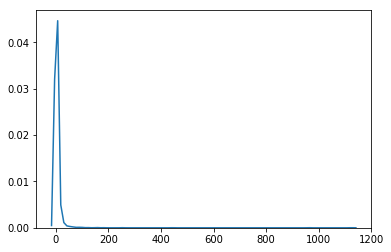

In [87]:
sns.kdeplot(feature_count)

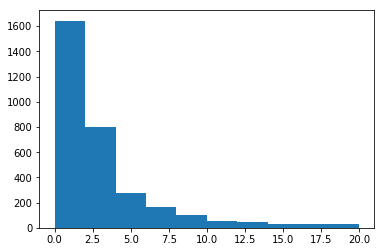

In [88]:
plt.hist(feature_count,range=(0,20));

In [89]:
def filtered_features(df,tol):
    features_filter = (df.iloc[:,1:].sum()>=tol).values.tolist()
    df_cols = df.columns[[True]+features_filter]
    df_filter = df[df_cols].copy()
    df_filter.reset_index(drop=True,inplace=True)
    print(df_filter.info())
    return df_filter

In [134]:
df_join_class_filt5 = filtered_features(df_join_class,5)
df_join_class_filt5.to_pickle('pickles/df_join_class_filt5.pkl')
df_join_superclass_filt5 = filtered_features(df_join_superclass,5)
df_join_superclass_filt5.to_pickle('pickles/df_join_superclass_filt5.pkl')
df_join_class_filt10 = filtered_features(df_join_class,10)
df_join_class_filt10.to_pickle('pickles/df_join_class_filt10.pkl')
df_join_superclass_filt10 = filtered_features(df_join_superclass,10)
df_join_superclass_filt10.to_pickle('pickles/df_join_superclass_filt10.pkl')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Columns: 681 entries, drug_id to targetact_BE0004854_antagonist
dtypes: bool(680), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Columns: 592 entries, drug_id to targetact_BE0004854_antagonist
dtypes: bool(591), object(1)
memory usage: 3.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Columns: 312 entries, drug_id to targetact_BE0004796_unknown
dtypes: bool(311), object(1)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Columns: 257 entries, drug_id to targetact_BE0004796_unknown
dtypes: bool(256), object(1)
memory usage: 1.5+ MB
None
